# IMPORT

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D

# FUNCTION DEFINITIONS

In [38]:
def to_rad(x):
    return x*np.pi/180

def multiwrite(outfile, string):
    outfile.write(string + "\n")
    print(string)
    
def fit_function(theta, A, m, s, r, a, b):
    # A: normalization, m: average, 2s: FWHM of Lorentzian, r: relative ratio, a b linear parameters, xi initial point of the fit, xf final point of the fit
    sg = s/np.sqrt(2*np.log(2)) # sigma of gaussian
    lor = A/np.pi*s/((theta-m)**2+s**2)
    gaus = A/(sg*np.sqrt(2*np.pi))*np.exp(-(theta-m)**2/(2*sg**2))
    line = a*l+b
    return r*lor + (1-r)*gaus + line

def d(theta):
    return l/(2*np.sin(theta))

def d_err(theta, theta_err):
    return l*np.array(theta_err)/(2*np.tan(theta)*np.sin(theta))

def lattice_constant(d, h, k, l):
    return  d*np.sqrt(h**2+k**2+l**2)

def lattice_constant_err(d_err, h, k, l):
    return  d_err*np.sqrt(h**2+k**2+l**2)

def beta_size(beta_obs):
    return np.sqrt(beta_obs**2-beta_instr**2)

def beta_size_err(beta_obs, beta_obs_err):
    return beta_obs*beta_obs_err/np.sqrt(beta_obs**2-beta_instr**2)

def Scherrer(theta, beta):
    return K*l/(beta*np.cos(theta))

def Scherrer_err(theta, theta_err, beta, beta_err):
    return np.sqrt( ((K*l/(np.cos(theta)*np.array(beta)**2))**2)*np.array(beta_err)**2 + ((K*l/(np.tan(theta)*np.sin(theta)*np.array(beta)))**2)*np.array(theta_err)**2 )

def Weighted_Average(array, weights):
    return (np.array(array)*np.array(weights)).sum()/(np.array(weights).sum())

# DATA

In [39]:
fs = 20 # standardize the fontsize
l = 0.15406 # [nm], from CuKa1
beta_instr = to_rad(0.27)
K = 0.89 # using FWHM

data = pd.read_csv("Group01_GIXRD1.txt", sep=" ", header=None)
data.columns = ["2theta", "intensity"]
two_theta_deg = np.array(data["2theta"]) # [deg], detector's angle
theta = np.array(data["2theta"])*np.pi/360 # [rad], Bragg's angle
intensity = np.array(data["intensity"]) #counts

# INTENSITY SPECTRUM PLOT

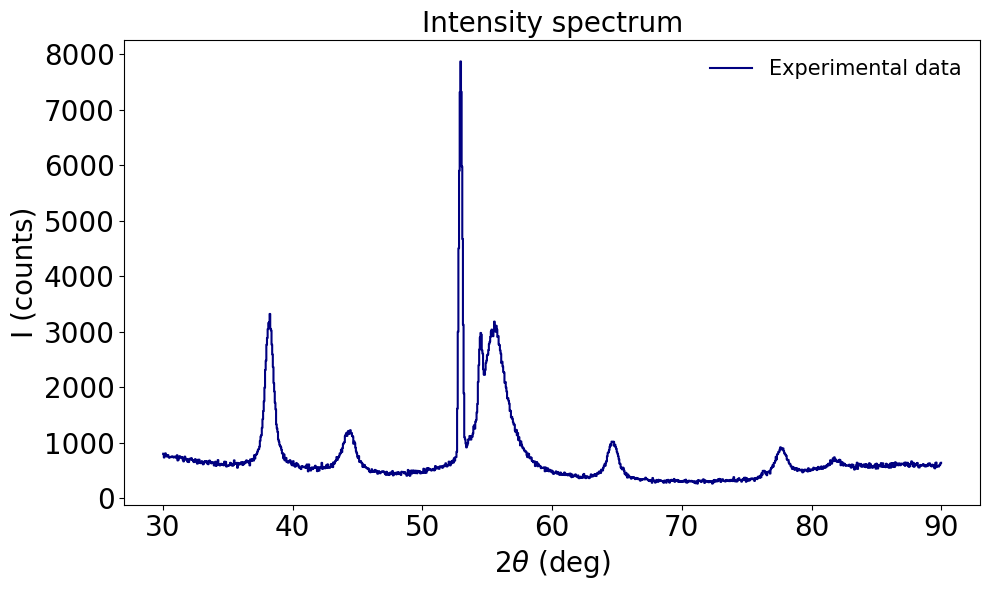

In [40]:
plt.figure(figsize=(10, 6), dpi=100)
plt.step(two_theta_deg, intensity, color="navy", label="Experimental data")
plt.title("Intensity spectrum", fontdict={"fontsize": fs})
plt.xlabel(r"$2\theta$ (deg)", fontdict={"fontsize": fs})
plt.xticks(fontsize=fs)
plt.ylabel("I (counts)", fontdict={"fontsize": fs})
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs//4*3, frameon=False)
plt.tight_layout()

# FITTING

/tmp/ipykernel_285/2491537262.py:88: RuntimeWarning: invalid value encountered in sqrt
  a_err.append(np.sqrt(par_cov[4,4]))
/tmp/ipykernel_285/2491537262.py:90: RuntimeWarning: invalid value encountered in sqrt
  b_err.append(np.sqrt(par_cov[5,5]))


Curve fit 1:
A = [115.632037542813, 41.92937937865182, 36.25342880736495, 29.58691304285473, 6.678777612558236] with errors [6.264127513461702, 4.378023670096646, 2.6035104408184067, 9.915013068848106, 5.770127360640421]
m = [0.3336962411421764, 0.387024587424115, 0.5645551290916743, 0.67823424017728, 0.7150536964807054] with errors [2.125755671446202e-05, 7.787980833330004e-05, 5.601363632120037e-05, 9.069250230271246e-05, 0.0002622705348428204]
s = [0.005931785295670363, 0.008628116480986736, 0.007545506800520178, 0.008135065955293324, 0.007602898538772103] with errors [0.00015513458649557928, 0.0004434472773799163, 0.0002763368039587959, 0.0011794445141693568, 0.002893839684259974]
FWHM = 2s = [0.011863570591340727, 0.017256232961973473, 0.015091013601040357, 0.016270131910586648, 0.015205797077544205] with errors [0.00031026917299115857, 0.0008868945547598326, 0.0005526736079175918, 0.0023588890283387136, 0.005787679368519948]
r = [1.637323500849171, 1.5788491517074474, 1.638301838

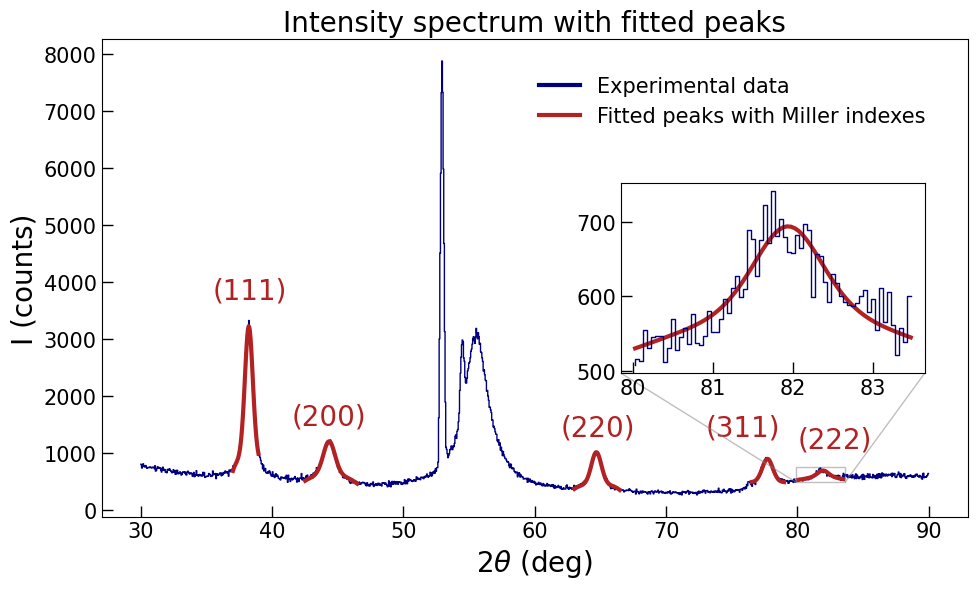

In [41]:
# creating couples of data with ranges of interest for the fits
two_theta_deg_peak1 = []
intensity_peak1 = []
two_theta_deg_peak2 = []
intensity_peak2 = []
two_theta_deg_peak3 = []
intensity_peak3 = []
two_theta_deg_peak4 = []
intensity_peak4 = []
two_theta_deg_peak5 = []
intensity_peak5 = []

for i in range(len(two_theta_deg)):
    if (two_theta_deg[i] >= 37 and two_theta_deg[i] <= 39):
        two_theta_deg_peak1.append(two_theta_deg[i])
        intensity_peak1.append(intensity[i])
    if (two_theta_deg[i] >= 42.5 and two_theta_deg[i] <= 46.5):
        two_theta_deg_peak2.append(two_theta_deg[i])
        intensity_peak2.append(intensity[i])
    if (two_theta_deg[i] >= 63 and two_theta_deg[i] <= 66.5):
        two_theta_deg_peak3.append(two_theta_deg[i])
        intensity_peak3.append(intensity[i])
    if (two_theta_deg[i] >= 76.5 and two_theta_deg[i] <= 79):
        two_theta_deg_peak4.append(two_theta_deg[i])
        intensity_peak4.append(intensity[i])
    if (two_theta_deg[i] >= 80 and two_theta_deg[i] <= 83.5):
        two_theta_deg_peak5.append(two_theta_deg[i])
        intensity_peak5.append(intensity[i])

# radiants conversion to use for fitting
theta_peak1 = np.array(two_theta_deg_peak1)*np.pi/360
theta_peak2 = np.array(two_theta_deg_peak2)*np.pi/360
theta_peak3 = np.array(two_theta_deg_peak3)*np.pi/360
theta_peak4 = np.array(two_theta_deg_peak4)*np.pi/360
theta_peak5 = np.array(two_theta_deg_peak5)*np.pi/360

# datas for fitting each of the 5 peaks
theta_peaks = [theta_peak1, theta_peak2, theta_peak3, theta_peak4, theta_peak5] # x data [rad]
intensity_peaks = [intensity_peak1,  intensity_peak2,  intensity_peak3,  intensity_peak4,  intensity_peak5] # y data

# initial guess for each parameter for fitting each of the 5 peaks
A_guess = [3000, 1200, 1000, 900, 800]
m_guess = np.array([19, 44, 65, 77, 82]) * np.pi / 360 # [rad]
s_guess = [0.5, 0.5, 0.5, 0.5, 0.5] # [rad]
r_guess = [0.5, 0.5, 0.5, 0.5, 0.5]
a_guess = [0, 0, 0, 0, 0]
b_guess = [700, 800, 600, -1000, 600]
bounds = ([0, 0, 0, 0, -np.inf, 0], [10000, 1, 1, 1, np.inf, 10000])

# create canvas
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

# plot all the data
ax.step(two_theta_deg, intensity, lw=1, color='navy')

FWHM = [] # this will be our beta observed (that is the sum of the beta size and beta instrumental)
FWHM_err = []
A_fit = []
A_err = []
m_fit = []
m_err = []
s_fit = []
s_err = []
r_fit = []
r_err = []
a_fit = []
a_err = []
b_fit = []
b_err = []
# unpack each array: every cycle is a fit on a peak
for x_fit, y_fit, A, m, s, r, a, b in zip(theta_peaks, intensity_peaks, A_guess, m_guess, s_guess, r_guess, a_guess, b_guess):
    # perform the fit
    par_fit, par_cov = curve_fit(fit_function, x_fit, y_fit, p0=(A, m, s, r, a, b), maxfev=5000)
    # plot each fit
    ax.plot(x_fit*360/np.pi, fit_function(x_fit, *par_fit), lw=3, color='firebrick') # pay attention, this is in [deg] just to have the plot
    # outputs
    FWHM.append(2*par_fit[2])
    FWHM_err.append(2*np.sqrt(par_cov[2,2]))
    A_fit.append(par_fit[0])
    A_err.append(np.sqrt(par_cov[0,0]))
    m_fit.append(par_fit[1])
    m_err.append(np.sqrt(par_cov[1,1]))
    s_fit.append(par_fit[2])
    s_err.append(np.sqrt(par_cov[2,2]))
    r_fit.append(par_fit[3])
    r_err.append(np.sqrt(par_cov[3,3]))
    a_fit.append(par_fit[4])
    a_err.append(np.sqrt(par_cov[4,4]))
    b_fit.append(par_fit[5])
    b_err.append(np.sqrt(par_cov[5,5]))

# labels
ax.set_title("Intensity spectrum with fitted peaks", fontdict={"fontsize": fs})
ax.set_xlabel(r"$2\theta$ (deg)", fontdict={"fontsize": fs})
ax.set_ylabel("I (counts)", fontdict={"fontsize": fs})

# writing legend by hand for fitted peaks (to avoid multiple outputs)
legend_elements = [Line2D([0], [0], color='navy', lw=3, label='Experimental data'),
                   Line2D([0], [0], color='firebrick', lw=3, label='Fitted peaks with Miller indexes')]
ax.legend(handles=legend_elements, loc=(0.495, 0.8), frameon=False, fontsize=fs//4*3)

# handling ticks
ax.tick_params(which='both', width=1.0, length=8, direction='in', labelsize=fs//4*3)

# zoom
inax = ax.inset_axes([0.6, 0.3, 0.35, 0.4])
inax.plot(theta_peak5*360/np.pi, fit_function(x_fit, *par_fit), lw=3, color='firebrick')
inax.step(theta_peak5*360/np.pi, intensity_peak5, lw=1, color='navy')
ax.indicate_inset_zoom(inax)

# handling ticks
inax.tick_params(which='both', width=1.0, length=8, direction='in', labelsize=fs//4*3)

# assign miller indexes
ax.text(35.5, 3700, '(111)', fontdict=None, fontsize = fs, color ="firebrick")
ax.text(41.5, 1500, '(200)', fontdict=None, fontsize = fs, color ="firebrick")
ax.text(62, 1300, '(220)', fontdict=None, fontsize = fs, color ="firebrick")
ax.text(73, 1300, '(311)', fontdict=None, fontsize = fs, color ="firebrick")
ax.text(80, 1100, '(222)', fontdict=None, fontsize = fs, color ="firebrick")

# manage layout and save
fig.tight_layout()

with open("outputfile2.txt", "w") as outfile:
    multiwrite(outfile, "Curve fit 1:")
    multiwrite(outfile, "A = " + str(A_fit) + " with errors " + str(A_err))
    multiwrite(outfile, "m = " + str(m_fit) + " with errors " + str(m_err))
    multiwrite(outfile, "s = " + str(s_fit) + " with errors " + str(s_err))
    multiwrite(outfile, "FWHM = 2s = " + str(FWHM) + " with errors " + str(FWHM_err))
    multiwrite(outfile, "r = " + str(r_fit) + " with errors " + str(r_err))
    multiwrite(outfile, "a = " + str(a_fit) + " with errors " + str(a_err))
    multiwrite(outfile, "b = " + str(b_fit) + " with errors " + str(b_err))
    multiwrite(outfile, "")

# LATTICE CONSTANT AND PARTICLE SIZE

In [42]:
# LATTICE CONSTANT

d_fit = d(m_fit)
d_fit_err = d_err(m_fit, m_err) 

latt = np.zeros(5)
latt_err = np.zeros(5)
latt[0] = lattice_constant(d_fit[0], 1, 1, 1)
latt[1] = lattice_constant(d_fit[1], 2, 0, 0)
latt[2] = lattice_constant(d_fit[2], 2, 2, 0)
latt[3] = lattice_constant(d_fit[3], 3, 1, 1)
latt[4] = lattice_constant(d_fit[4], 2, 2, 2)
latt_err[0] = lattice_constant_err(d_fit_err[0], 1, 1, 1)
latt_err[1] = lattice_constant_err(d_fit_err[1], 2, 0, 0)
latt_err[2] = lattice_constant_err(d_fit_err[2], 2, 2, 0)
latt_err[3] = lattice_constant_err(d_fit_err[3], 3, 1, 1)
latt_err[4] = lattice_constant_err(d_fit_err[4], 2, 2, 2)

latt_av = np.average(latt)
latt_av_err = np.std(latt)/np.sqrt(len(latt))

latt_w_av = Weighted_Average(latt, A_fit)
# TODO: error propagation on weighted average



# PARTICLE SIZE

beta = []
beta_err = []
for i in range(len(FWHM)):
    beta = beta_size(FWHM[i])
    beta_err = beta_size_err(FWHM[i], FWHM_err[i])

R_v = Scherrer(m_fit, beta)/2  # volume weighted radius
R_v_err = Scherrer_err(m_fit, m_err, beta, beta_err)/2

R_v_av = np.average(R_v)
R_v_av_err = np.std(R_v)/np.sqrt(len(R_v))

R_v_w_av = Weighted_Average(R_v, A_fit)
# TODO: error propagation on weighted average



# OUTPUTS

with open("outputfile2.txt", "a") as outfile:
    multiwrite(outfile, "lattice constants = " + str(latt) + " nm with errors " + str(latt_err) + " nm" )
    multiwrite(outfile, "lattice constant average = " + str(latt_av) + " nm with error " + str(latt_av_err) + " nm" )
    multiwrite(outfile, "lattice constant weighted average= " + str(latt_w_av) + " nm with error " + str("TODO") + " nm" )
    multiwrite(outfile, "volumic radii = " + str(R_v) + " nm with errors " + str(R_v_err) + " nm" )
    multiwrite(outfile, "volumic radius average = " + str(R_v_av) + " nm with error " + str(R_v_av_err) + " nm" )
    multiwrite(outfile, "volumic radius weighted average = " + str(R_v_w_av) + " nm with error " + str("TODO") + " nm" )
    multiwrite(outfile, "")



# TODO:
# error propagation on weighted averages


lattice constants = [0.40734215 0.40817651 0.40721017 0.40719135 0.40698011] nm with errors [2.49786489e-05 7.79935983e-05 3.60158560e-05 4.58323648e-05
 1.22920885e-04] nm
lattice constant average = 0.40738005891891227 nm with error 0.00018549484964230155 nm
lattice constant weighted average= 0.4074435063785764 nm with error TODO nm
volumic radii = [5.01890891 5.12081133 5.61305239 6.08985153 6.28038686] nm with errors [2.11327813 2.15618664 2.36345004 2.56421263 2.64444081] nm
volumic radius average = 5.62460220239958 nm with error 0.22515003582488494 nm
volumic radius weighted average = 5.305432319706017 nm with error TODO nm

